<a href="https://colab.research.google.com/github/snehamartin30/COVID/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
covid_file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
influenza_file_path = '/content/drive/My Drive/FINAL PROJECT/influenza_data.csv'
socioeconomic_file_path = '/content/drive/My Drive/FINAL PROJECT/socioeconomic_data.csv'
climate_change_file_path = '/content/drive/MyDrive/FINAL PROJECT/climate_change_data.csv'
healthcare_file_path = '/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv'

In [4]:
#Preprocess Each Dataset with Imputation

def impute_with_sampling(df, column):
    non_zero_non_na_values = df.loc[(df[column] != 0) & (~df[column].isna()), column]
    df.loc[df[column].isna() | (df[column] == 0), column] = np.random.choice(non_zero_non_na_values, size=df.loc[df[column].isna() | (df[column] == 0), column].shape[0], replace=True)
    return df


In [5]:
import pandas as pd

# Load the daily COVID data from the CSV file
file_path = '/content/drive/MyDrive/FINAL PROJECT/covid_data.csv'
covid_data = pd.read_csv(file_path)

# Convert the 'date' column to datetime format
covid_data['date'] = pd.to_datetime(covid_data['date'], errors='coerce')

# Sort the data by location and date
covid_data.sort_values(by=['location', 'date'], inplace=True)

# Resample the data on a quarterly basis for each location, using the end of the quarter
quarterly_data = covid_data.groupby('location').resample('Q', on='date').mean(numeric_only=True).reset_index()

# Compute the quarterly rolling average for relevant columns within each location
for column in ['new_cases', 'new_deaths']:
    quarterly_data[f'{column}_quarterly_avg'] = quarterly_data.groupby('location')[column].rolling(window=1).mean().reset_index(0, drop=True)

# Include the 'location' column in the quarterly data
quarterly_data = quarterly_data[['location', 'date'] + [col for col in quarterly_data.columns if col not in ['location', 'date']]]

# Save the quarterly data to a new CSV file
quarterly_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/quarterly_covid_data.csv', index=False)
print("Quarterly data with rolling averages has been saved to 'quarterly_covid_data.csv'")

# Preprocess Quarterly COVID Data
# Load the CSV file
quarterly_covid_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/quarterly_covid_data.csv')

# Correct column names based on inspection
quarterly_covid_columns_to_keep = ['location','date','total_cases', 'total_deaths','reproduction_rate','people_fully_vaccinated','gdp_per_capita','population','hosp_patients', 'population_density', 'life_expectancy', 'human_development_index']

# Drop unnecessary columns
quarterly_covid_data = quarterly_covid_data[quarterly_covid_columns_to_keep]

# Impute missing or zero values
for column in quarterly_covid_columns_to_keep[1:]:
    quarterly_covid_data = impute_with_sampling(quarterly_covid_data, column)

# Selecting relevant columns
quarterly_covid_data_selected = quarterly_covid_data[['location','date','total_cases','total_deaths','reproduction_rate','people_fully_vaccinated','gdp_per_capita','population', 'population_density', 'life_expectancy', 'human_development_index']]
print(quarterly_covid_data_selected.head())

Quarterly data with rolling averages has been saved to 'quarterly_covid_data.csv'
      location        date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan  2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan  2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan  2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan  2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan  2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  population_density  \
0             1.164142e+04        1803.987  39835428.0              54.422   
1             9.187000e+03        1803.987  39835428.0              54.422   
2             1.268073e+07        1803.987  39835428.0              54.422   
3             3.193772e+06        1803.987  39835428.0              54.422   
4             2.578724e+05        1803.987  39835428.0           

In [6]:
#Preprocess Influenza Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/influenza_data.csv'
influenza_data = pd.read_csv(file_path)


# Columns to impute
influenza_columns = ['All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']

# Impute each column
for column in influenza_columns:
    influenza_data = impute_with_sampling(influenza_data, column)

# Selecting relevant columns
influenza_data_selected = influenza_data[['Day', 'All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']]
print(influenza_data_selected.head())

# Convert the 'Day' column to datetime format
influenza_data['Day'] = pd.to_datetime(influenza_data['Day'], errors='coerce')

# Check the data types to confirm the conversion
print(influenza_data.dtypes)

# Define the start and end dates for the filter
start_date = '2020-01-01'
end_date = '2022-12-31'

# Filter the data based on the 'Day' column
influenza_data_filtered = influenza_data[(influenza_data['Day'] >= start_date) & (influenza_data['Day'] <= end_date)]

# Select relevant columns if needed
influenza_data_filtered = influenza_data_filtered[['Country','Day', 'All strains - All types of surveillance', 'Reported deaths caused by severe acute respiratory infections', 'Cases of influenza-like illnesses', 'Share of positive tests - All types of surveillance']]

# Resample the data on a quarterly basis for each country, using the end of the quarter
quarterly_influenza_data = influenza_data_filtered.groupby('Country').resample('Q', on='Day').mean().reset_index()

# Include the 'Country' column in the quarterly data
quarterly_influenza_data = quarterly_influenza_data[['Country', 'Day'] + [col for col in quarterly_influenza_data.columns if col not in ['Country', 'Day']]]

# Save the quarterly data to a new CSV file
filtered_file_path = '/content/drive/MyDrive/FINAL PROJECT/quarterly_influenza_data.csv'
quarterly_influenza_data.to_csv(filtered_file_path, index=False)

# Print the first few rows and the shape of the quarterly data
print(quarterly_influenza_data.head())
print(f"Quarterly data shape: {quarterly_influenza_data.shape}")

          Day  All strains - All types of surveillance  \
0  2009-09-28                                      3.0   
1  2009-10-05                                      1.0   
2  2009-10-12                                      1.0   
3  2009-10-19                                     98.0   
4  2009-10-26                                     64.0   

   Reported deaths caused by severe acute respiratory infections  \
0                                                2.0               
1                                                5.0               
2                                                1.0               
3                                               18.0               
4                                                5.0               

   Cases of influenza-like illnesses  \
0                              718.0   
1                             1622.0   
2                           112622.0   
3                               36.0   
4                               15.0   

 

In [7]:
#Preprocess Socioeconomic Data

file_path = '/content/drive/MyDrive/FINAL PROJECT/socioeconomic_data.csv'
socioeconomic_data = pd.read_csv(file_path)

# Columns to impute
socioeconomic_columns = ['Latitude','Country']

# Impute each column
for column in socioeconomic_columns:
    socioeconomic_data = impute_with_sampling(socioeconomic_data, column)

# Selecting relevant columns
socioeconomic_data_selected = socioeconomic_data[['Latitude','Longitude','Country']]
print(socioeconomic_data_selected.head())


    Latitude  Longitude      Country
0  33.939110  67.709953  Afghanistan
1  41.153332  20.168331      Albania
2  28.033886   1.659626      Algeria
3  42.506285   1.521801      Andorra
4 -11.202692  17.873887       Angola


In [8]:
#Preprocess climate data
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the climate change data
climate_file_path = '/content/drive/MyDrive/FINAL PROJECT/climate_change_data.csv'
climate_data = pd.read_csv(climate_file_path)


# Convert the 'Date' column to datetime format
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')

# Filter the data to include only records from 2020 to 2022
start_date = '2020-01-01'
end_date = '2022-12-31'
climate_data = climate_data[(climate_data['Date'] >= start_date) & (climate_data['Date'] <= end_date)]



# Sort the data by Country and Date
climate_data.sort_values(by=['Country', 'Date'], inplace=True)

# Identify the numeric columns and exclude 'Sea Level Rise'
numeric_columns = ['Temperature', 'CO2 Emissions', 'Precipitation', 'Humidity', 'Wind Speed']

# Group by 'Country' and resample the numeric data on a quarterly basis
quarterly_numeric_data = climate_data.groupby('Country').resample('Q', on='Date')[numeric_columns].mean().reset_index()

# Impute NaN values using mean imputation
imputer = SimpleImputer(strategy='mean')
quarterly_numeric_data[numeric_columns] = imputer.fit_transform(quarterly_numeric_data[numeric_columns])

# Ensure the 'Country' column is included in the quarterly data
quarterly_climate_data = quarterly_numeric_data[['Country', 'Date'] + numeric_columns]

# Save the quarterly data to a new CSV file
quarterly_file_path = '/content/drive/MyDrive/FINAL PROJECT/quarterly_climate_data.csv'  # Adjust this path as needed
quarterly_climate_data.to_csv(quarterly_file_path, index=False)

# Print the first few rows and the shape of the quarterly data
print(quarterly_climate_data.head())
print(f"Quarterly data shape: {quarterly_climate_data.shape}")


       Country       Date  Temperature  CO2 Emissions  Precipitation  \
0  Afghanistan 2020-03-31     6.675645     377.580973      97.282837   
1  Afghanistan 2020-06-30    14.958386     398.346017      48.685676   
2  Afghanistan 2020-09-30    14.958386     398.346017      48.685676   
3  Afghanistan 2020-12-31    14.958386     398.346017      48.685676   
4  Afghanistan 2021-03-31    14.958386     398.346017      48.685676   

    Humidity  Wind Speed  
0  35.274872   39.198311  
1  49.712111   25.180540  
2  49.712111   25.180540  
3  49.712111   25.180540  
4  49.712111   25.180540  
Quarterly data shape: (2122, 7)


In [9]:
# Load the healthcare dataset
healthcare_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_data.csv')

# Drop unnecessary columns
columns_to_keep = ['Country Name', 'Year', 'Value']
healthcare_data = healthcare_data[columns_to_keep]

# Drop rows with NaN in 'Year' column, since we cannot process them
healthcare_data = healthcare_data.dropna(subset=['Year'])

# Ensure 'Year' column is an integer
healthcare_data['Year'] = healthcare_data['Year'].astype(int)

# Create a 'date' column for the end of each year
healthcare_data['date'] = pd.to_datetime(healthcare_data['Year'].astype(str) + '-12-31')

# Repeat yearly values for each quarter
quarters = ['03-31', '06-30', '09-30', '12-31']
quarterly_rows = []

for idx, row in healthcare_data.iterrows():
    for quarter in quarters:
        new_row = row.copy()
        new_row['date'] = pd.to_datetime(f"{row['Year']}-{quarter}")
        quarterly_rows.append(new_row)

healthcare_quarterly_data = pd.DataFrame(quarterly_rows)

# Rename columns to match other datasets
healthcare_quarterly_data.rename(columns={'Country Name': 'location'}, inplace=True)
# Fill NaN values with imputation
imputer = SimpleImputer(strategy='mean')
healthcare_quarterly_data['Value'] = imputer.fit_transform(healthcare_quarterly_data[['Value']])

# Save the quarterly data to a new CSV file
healthcare_quarterly_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_quarterly_data.csv', index=False)
print("Quarterly healthcare data has been saved to 'healthcare_quarterly_data.csv'")
# Print the first few rows and the shape of the quarterly data
print(healthcare_quarterly_data.head())
print(f"Quarterly data shape: {healthcare_quarterly_data.shape}")

Quarterly healthcare data has been saved to 'healthcare_quarterly_data.csv'
                      location  Year        Value       date
0                        Aruba  2010  1426.319488 2010-03-31
0                        Aruba  2010  1426.319488 2010-06-30
0                        Aruba  2010  1426.319488 2010-09-30
0                        Aruba  2010  1426.319488 2010-12-31
1  Africa Eastern and Southern  2010   198.329791 2010-03-31
Quarterly data shape: (14896, 4)


In [10]:
# Apply the mapping

#Define the location mapping
location_mapping = {
    'Original Country Name 1': 'Standardized Country Name',
    'Original Country Name 2': 'Standardized Country Name',

}

# Rename columns to 'location' for consistency
quarterly_covid_data.rename(columns={'location': 'location'}, inplace=True)
quarterly_influenza_data.rename(columns={'Country': 'location'}, inplace=True)
quarterly_climate_data.rename(columns={'Country': 'location'}, inplace=True)
healthcare_quarterly_data.rename(columns={'Country Name': 'location'}, inplace=True)

# Apply the location mapping to each dataset
quarterly_covid_data['location'] = quarterly_covid_data['location'].replace(location_mapping)
quarterly_influenza_data['location'] = quarterly_influenza_data['location'].replace(location_mapping)
quarterly_climate_data['location'] = quarterly_climate_data['location'].replace(location_mapping)
healthcare_quarterly_data['location'] = healthcare_quarterly_data['location'].replace(location_mapping)

# Print updated datasets to verify changes
print("Updated quarterly_covid_data:")
print(quarterly_covid_data.head())

print("\nUpdated quarterly_influenza_data:")
print(quarterly_influenza_data.head())

print("\nUpdated quarterly_climate_data:")
print(quarterly_climate_data.head())

print("\nUpdated healthcare_quarterly_data:")
print(healthcare_quarterly_data.head())

Updated quarterly_covid_data:
      location        date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan  2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan  2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan  2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan  2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan  2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  hosp_patients  \
0             1.164142e+04        1803.987  39835428.0     386.274725   
1             9.187000e+03        1803.987  39835428.0      15.032258   
2             1.268073e+07        1803.987  39835428.0   12094.307692   
3             3.193772e+06        1803.987  39835428.0    1188.098901   
4             2.578724e+05        1803.987  39835428.0     684.369565   

   population_density  life_expectancy  human_development_index  
0 

In [11]:
# Print column names to verify
print("quarterly_covid_data columns:", quarterly_covid_data.columns)
print("quarterly_influenza_data columns:", quarterly_influenza_data.columns)
print("quarterly_climate_data columns:", quarterly_climate_data.columns)
print("healthcare_quarterly_data columns:", healthcare_quarterly_data.columns)

quarterly_covid_data columns: Index(['location', 'date', 'total_cases', 'total_deaths', 'reproduction_rate',
       'people_fully_vaccinated', 'gdp_per_capita', 'population',
       'hosp_patients', 'population_density', 'life_expectancy',
       'human_development_index'],
      dtype='object')
quarterly_influenza_data columns: Index(['location', 'Day', 'All strains - All types of surveillance',
       'Reported deaths caused by severe acute respiratory infections',
       'Cases of influenza-like illnesses',
       'Share of positive tests - All types of surveillance'],
      dtype='object')
quarterly_climate_data columns: Index(['location', 'Date', 'Temperature', 'CO2 Emissions', 'Precipitation',
       'Humidity', 'Wind Speed'],
      dtype='object')
healthcare_quarterly_data columns: Index(['location', 'Year', 'Value', 'date'], dtype='object')


In [12]:
# Check for duplicate dates within each dataset
# Rename 'Day' column to 'date' in the quarterly_influenza_data dataset
quarterly_influenza_data.rename(columns={'Day': 'date'}, inplace=True)

# Rename 'Date' column to 'date' in the quarterly_climate_data dataset
quarterly_climate_data.rename(columns={'Date': 'date'}, inplace=True)

# Check for duplicate dates within each dataset
print("Quarterly COVID Data:")
print(quarterly_covid_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Quarterly Influenza Data:")
print(quarterly_influenza_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Quarterly Climate Data:")
print(quarterly_climate_data.groupby(['location', 'date']).size().reset_index(name='counts'))

print("Healthcare Quarterly Data:")
print(healthcare_quarterly_data.groupby(['location', 'date']).size().reset_index(name='counts'))



Quarterly COVID Data:
         location        date  counts
0     Afghanistan  2020-03-31       1
1     Afghanistan  2020-06-30       1
2     Afghanistan  2020-09-30       1
3     Afghanistan  2020-12-31       1
4     Afghanistan  2021-03-31       1
...           ...         ...     ...
2032     Zimbabwe  2021-03-31       1
2033     Zimbabwe  2021-06-30       1
2034     Zimbabwe  2021-09-30       1
2035     Zimbabwe  2021-12-31       1
2036     Zimbabwe  2022-03-31       1

[2037 rows x 3 columns]
Quarterly Influenza Data:
         location       date  counts
0     Afghanistan 2020-03-31       1
1     Afghanistan 2020-06-30       1
2     Afghanistan 2020-09-30       1
3     Afghanistan 2020-12-31       1
4     Afghanistan 2021-03-31       1
...           ...        ...     ...
2349     Zimbabwe 2021-12-31       1
2350     Zimbabwe 2022-03-31       1
2351     Zimbabwe 2022-06-30       1
2352     Zimbabwe 2022-09-30       1
2353     Zimbabwe 2022-12-31       1

[2354 rows x 3 columns]
Qu

In [13]:


# Load the healthcare data
healthcare_quarterly_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/healthcare_quarterly_data.csv')

# Rename 'Value' column to 'health_expenditure'
healthcare_quarterly_data.rename(columns={'Value': 'health_expenditure'}, inplace=True)

# Generate quarterly dates for each year
def expand_to_quarterly(df):
    quarters = ['03-31', '06-30', '09-30', '12-31']
    expanded_data = []
    for _, row in df.iterrows():
        for quarter in quarters:
            date = f"{int(row['Year'])}-{quarter}"
            expanded_data.append({
                'location': row['location'],
                'health_expenditure': row['health_expenditure'],
                'date': date
            })
    return pd.DataFrame(expanded_data)



# Apply the expansion function
healthcare_quarterly_data = expand_to_quarterly(healthcare_quarterly_data)

# Convert 'date' to datetime format
healthcare_quarterly_data['date'] = pd.to_datetime(healthcare_quarterly_data['date'], format='%Y-%m-%d')


# Filter data to include only the years 2020 to 2022
healthcare_quarterly_data = healthcare_quarterly_data[
    (healthcare_quarterly_data['date'].dt.year >= 2020) & (healthcare_quarterly_data['date'].dt.year <= 2022)
]

# Print to verify
print("Updated healthcare_quarterly_data:")
print(healthcare_quarterly_data.head())



Updated healthcare_quarterly_data:
      location  health_expenditure       date
42560    Aruba         1426.319488 2020-03-31
42561    Aruba         1426.319488 2020-06-30
42562    Aruba         1426.319488 2020-09-30
42563    Aruba         1426.319488 2020-12-31
42564    Aruba         1426.319488 2020-03-31


In [14]:
# Remove duplicates before merging
quarterly_covid_data = quarterly_covid_data.drop_duplicates()
quarterly_influenza_data = quarterly_influenza_data.drop_duplicates()
quarterly_climate_data = quarterly_climate_data.drop_duplicates()
healthcare_quarterly_data = healthcare_quarterly_data.drop_duplicates()

# Convert 'date' columns to datetime format in all datasets
quarterly_covid_data['date'] = pd.to_datetime(quarterly_covid_data['date'])
quarterly_influenza_data['date'] = pd.to_datetime(quarterly_influenza_data['date'])
quarterly_climate_data['date'] = pd.to_datetime(quarterly_climate_data['date'])
healthcare_quarterly_data['date'] = pd.to_datetime(healthcare_quarterly_data['date'])

# Merge datasets on 'location' and 'date'
merged_data = quarterly_covid_data.merge(
    quarterly_influenza_data,
    on=['location', 'date'],
    how='inner'
).merge(
    quarterly_climate_data,
    on=['location', 'date'],
    how='inner'
).merge(
    healthcare_quarterly_data,
    on=['location', 'date'],
    how='inner'
)

# Print the merged data to verify
print(merged_data.head())

#save merged data

      location       date   total_cases  total_deaths  reproduction_rate  \
0  Afghanistan 2020-03-31     31.648649      2.333333           1.513333   
1  Afghanistan 2020-06-30  10984.142857    227.670330           1.312088   
2  Afghanistan 2020-09-30  37075.130435   1289.206522           0.871848   
3  Afghanistan 2020-12-31  44457.728261   1707.619565           1.123478   
4  Afghanistan 2021-03-31  55126.988889   2399.800000           0.917000   

   people_fully_vaccinated  gdp_per_capita  population  hosp_patients  \
0             1.164142e+04        1803.987  39835428.0     386.274725   
1             9.187000e+03        1803.987  39835428.0      15.032258   
2             1.268073e+07        1803.987  39835428.0   12094.307692   
3             3.193772e+06        1803.987  39835428.0    1188.098901   
4             2.578724e+05        1803.987  39835428.0     684.369565   

   population_density  ...  All strains - All types of surveillance  \
0              54.422  ...       

<ipython-input-14-3e71929e9185>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthcare_quarterly_data['date'] = pd.to_datetime(healthcare_quarterly_data['date'])


In [15]:
# Load the datasets
merged_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/finalmerged_data.csv')
socioeconomic_data = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT/socioeconomic_data.csv')


# Rename 'country' to 'location' in socioeconomic_data
socioeconomic_data.rename(columns={'Country': 'location'}, inplace=True)

# Merge socioeconomic_data with merged_data on 'location'
project_merged_data = pd.merge(
    merged_data,
    socioeconomic_data[['location', 'Latitude']],
    on='location',
    how='left'  # Use 'left' join to keep all rows from merged_data
)

# Save the final DataFrame to a CSV file
project_merged_data.to_csv('/content/drive/MyDrive/FINAL PROJECT/Project_merged_data.csv', index=False)

# Print the first few rows to verify
print("Project Merged Data:")
print(project_merged_data.head())

Project Merged Data:
      location        date   total_cases  total_deaths   new_cases  \
0  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
1  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
2  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
3  Afghanistan  2020-03-31     31.648649      2.333333    4.666667   
4  Afghanistan  2020-06-30  10984.142857    227.670330  343.725275   

   new_deaths  reproduction_rate  gdp_per_capita  population  hosp_patients  \
0    0.444444           1.513333        1803.987  39835428.0      12.939394   
1    0.444444           1.513333        1803.987  39835428.0      12.939394   
2    0.444444           1.513333        1803.987  39835428.0      12.939394   
3    0.444444           1.513333        1803.987  39835428.0      12.939394   
4    8.076923           1.312088        1803.987  39835428.0    1847.351648   

   ...  Reported deaths caused by severe acute respiratory infections  \
0  ...    

In [16]:
#Filtering data by countries


# Print unique values in the 'location' column
print(project_merged_data['location'].unique())

# Strip leading and trailing spaces from 'location' column
project_merged_data['location'] = project_merged_data['location'].str.strip()

developed_countries_list = [
    'Belgium','Bahrain','Israel', 'Finland',
    'France', 'Germany', 'Japan', 'Ireland', 'Italy',
    'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Portugal',
    'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States'
]

developing_countries_list = [
    'Bangladesh', 'Rwanda', 'China', 'India', 'Indonesia', 'Mexico',
    'South Africa', 'Thailand', 'Turkey'
]

underdeveloped_countries_list = [
    'Afghanistan', 'Nigeria', 'Chad', 'Ethiopia', 'Haiti', 'Madagascar',
    'Mali', 'Mozambique', 'Niger', 'Somalia'
]

islands_list = [
    'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Cuba', 'Dominica',
    'Fiji', 'Grenada', 'Jamaica', 'Kiribati', 'Maldives', 'Malta',
    'Marshall Islands', 'Mauritius', 'Palau', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Samoa', 'Seychelles', 'Solomon Islands',
    'Tonga', 'Trinidad and Tobago', 'Tuvalu', 'Vanuatu'
]


# Strip leading and trailing spaces from 'location' column
project_merged_data['location'] = project_merged_data['location'].str.strip()

# Filter data based on the corrected country lists
developed_countries = project_merged_data[project_merged_data['location'].isin(developed_countries_list)]
developing_countries = project_merged_data[project_merged_data['location'].isin(developing_countries_list)]
underdeveloped_countries = project_merged_data[project_merged_data['location'].isin(underdeveloped_countries_list)]
islands = project_merged_data[project_merged_data['location'].isin(islands_list)]

# Print the number of entries in each category to verify
print("Developed Countries Data:")
print(developed_countries)

print("Developing Countries Data:")
print(developing_countries)

print("Underdeveloped Countries Data:")
print(underdeveloped_countries)

print("Island Countries Data:")
print(islands)




['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria' 'Azerbaijan'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Bermuda'
 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'British Virgin Islands' 'Bulgaria' 'Burkina Faso' 'Cambodia' 'Cameroon'
 'Canada' 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba'
 'Denmark' 'Dominica' 'Dominican Republic' 'Ecuador' 'El Salvador'
 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'French Polynesia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea'
 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'India' 'Indonesia' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kiribati' 'Kuwait' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Madagascar' 'Malaysia' 'Maldives' 'Mali' 'Malta' 'Marshall Islands'
 'Mauritania' 'Mauritius' 'Mexico' 'Moldova' 'Mongo


--- EDA for Developed Countries ---
Dimensions of the dataset: (224, 24)

First few rows of the dataset:
    location        date   total_cases  total_deaths   new_cases  new_deaths  \
368  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
369  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
370  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
371  Bahrain  2020-06-30   9170.747253     21.758242  287.813187    0.912088   
372  Bahrain  2020-09-30  47592.706522    168.250000  479.413043    1.782609   

     reproduction_rate  gdp_per_capita  population  hosp_patients  ...  \
368           1.268791       43290.705   1748295.0     529.466667  ...   
369           1.268791       43290.705   1748295.0     529.466667  ...   
370           1.268791       43290.705   1748295.0     529.466667  ...   
371           1.268791       43290.705   1748295.0     529.466667  ...   
372           1.008913       43290.705   17

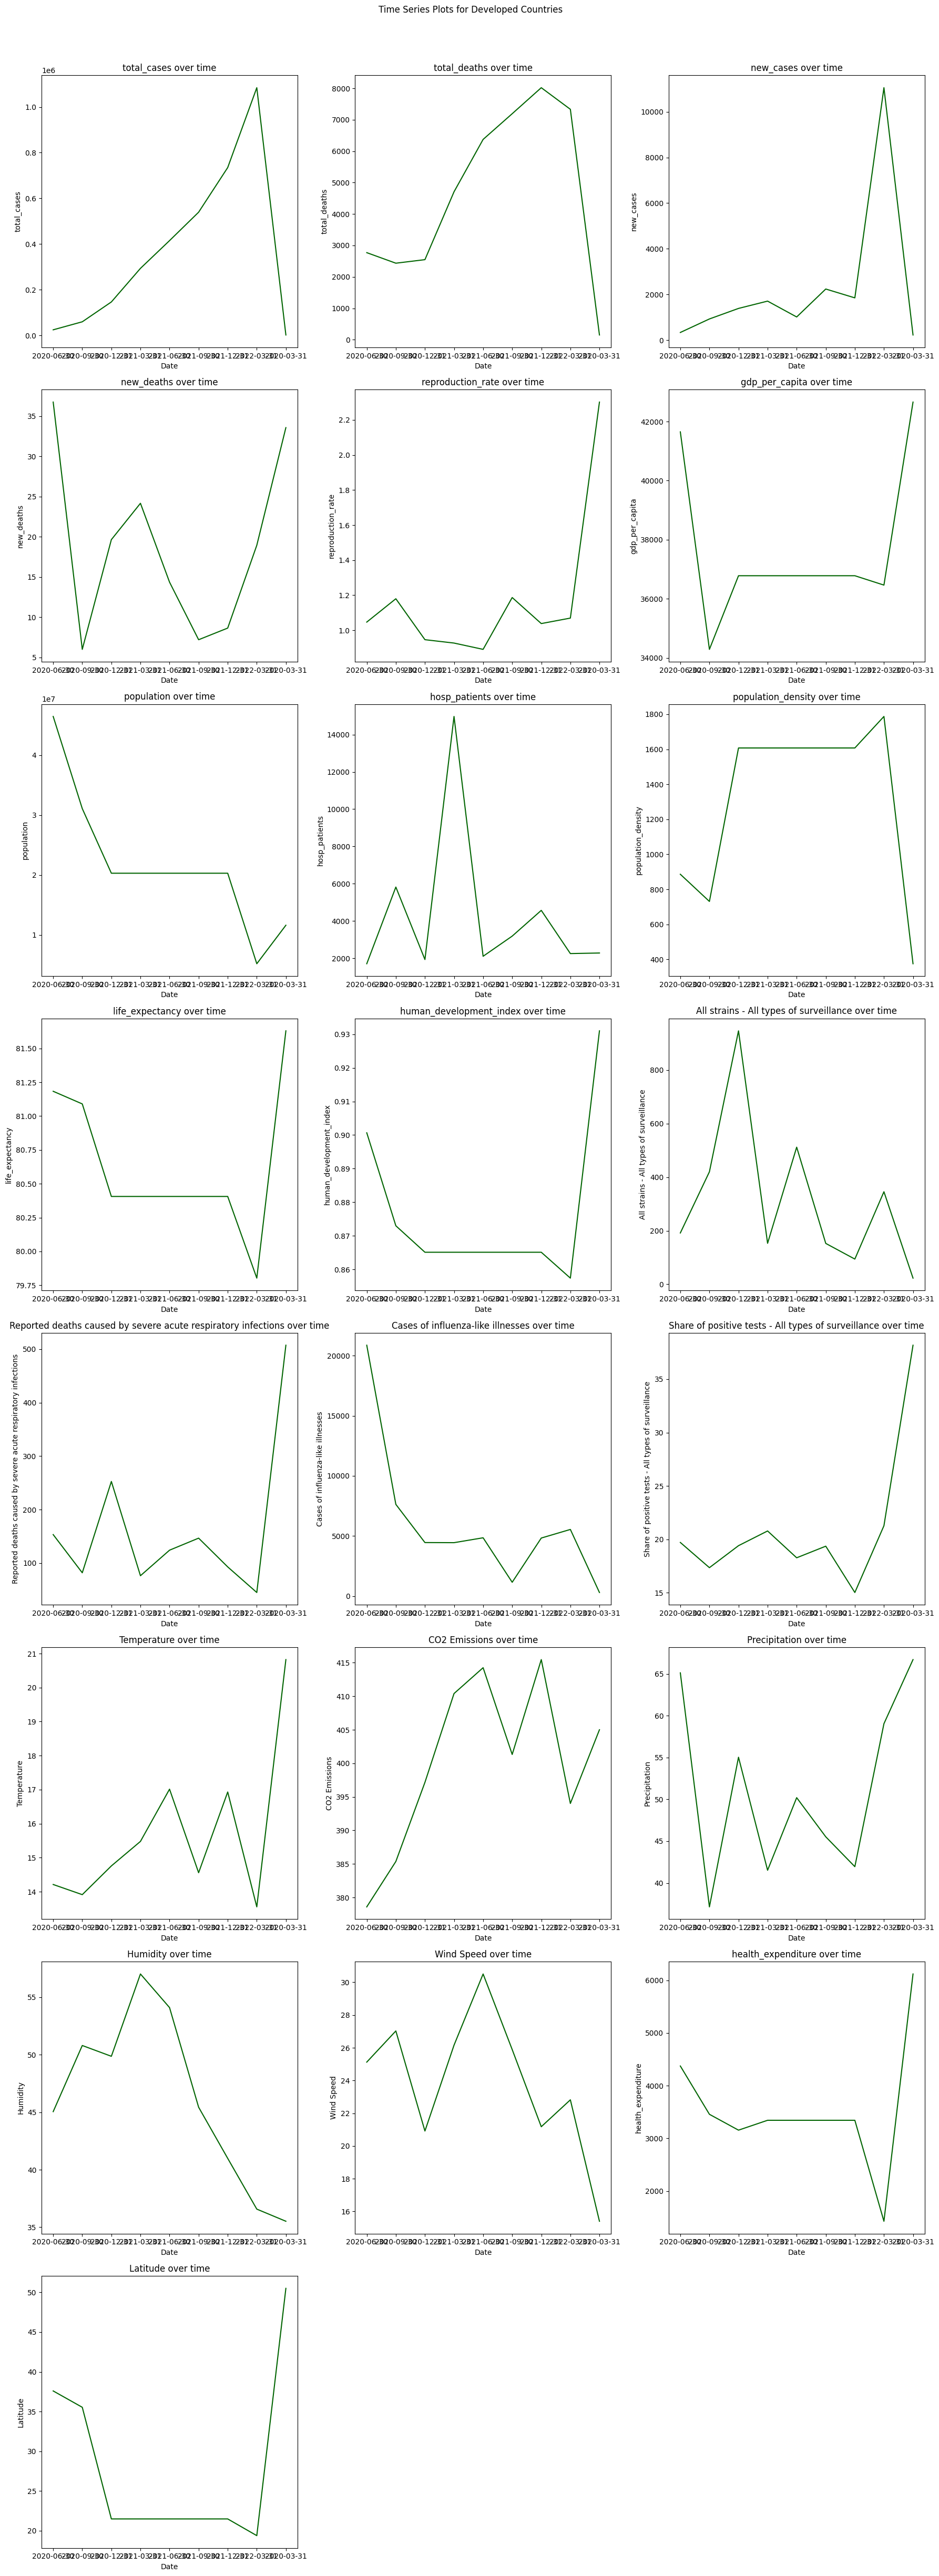

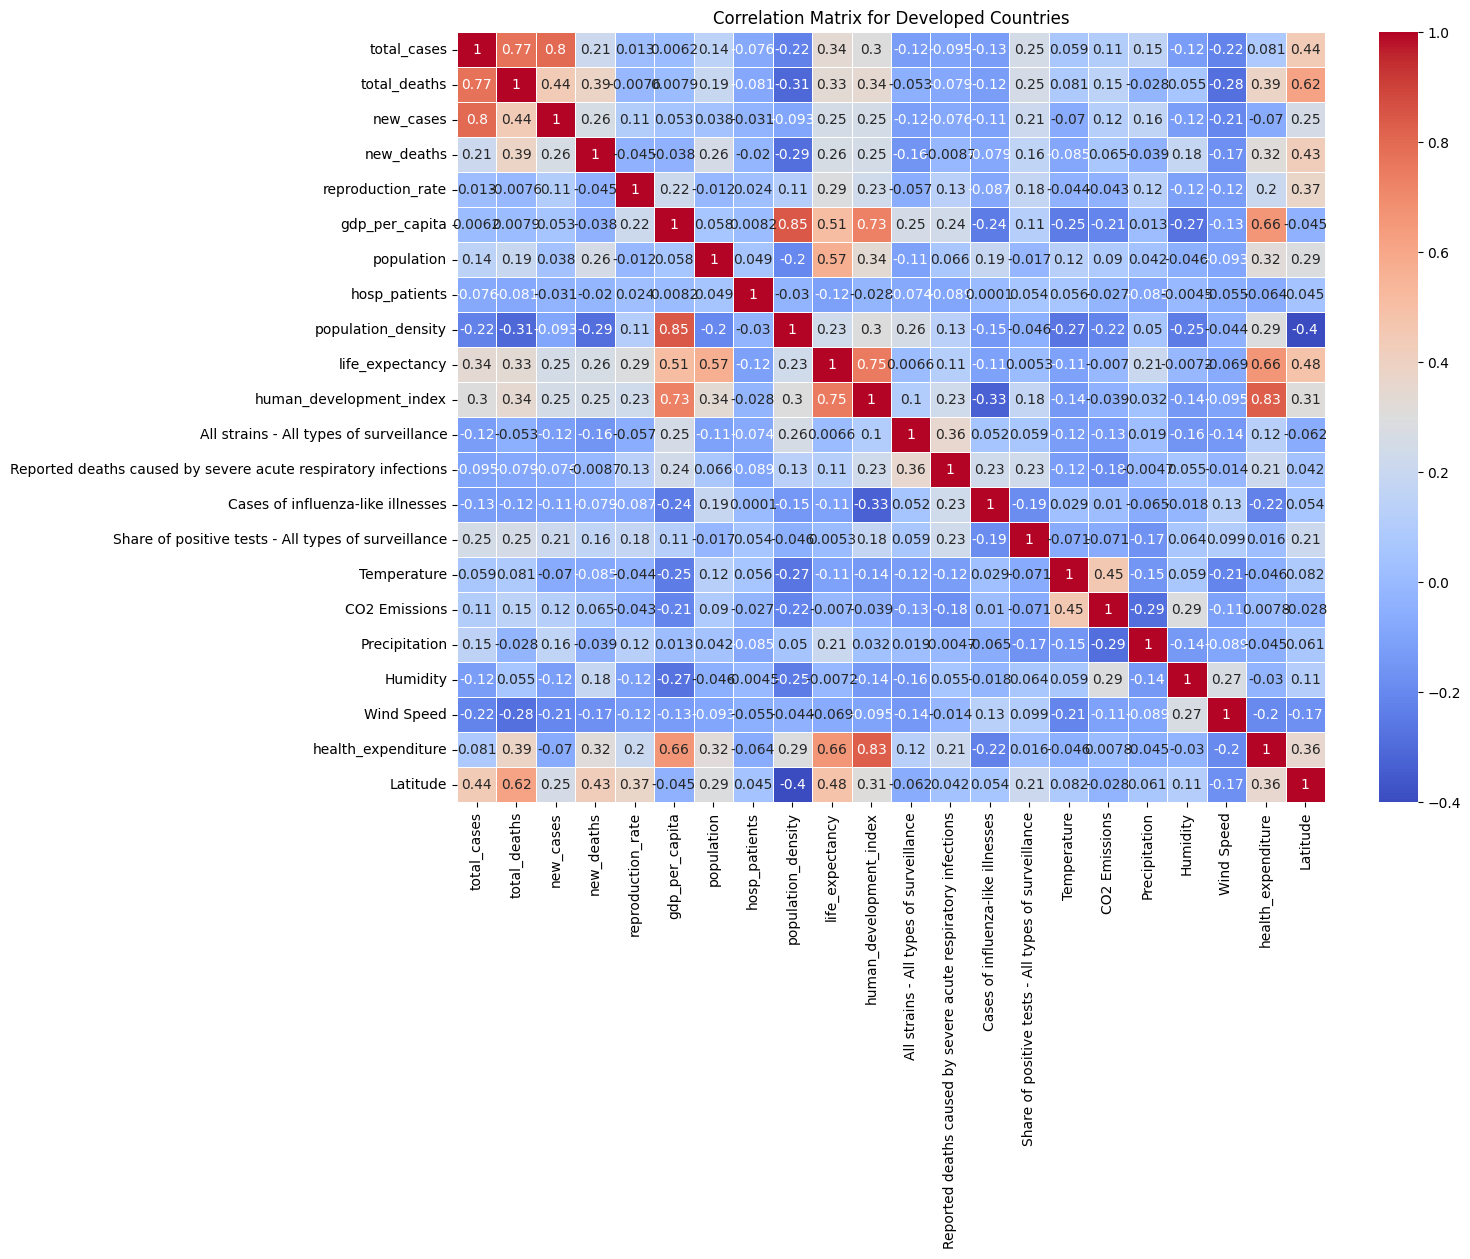


--- EDA for Developing Countries ---
Dimensions of the dataset: (188, 24)

First few rows of the dataset:
       location        date    total_cases  total_deaths    new_cases  \
400  Bangladesh  2020-12-31  438283.521739   6335.500000  1630.771739   
401  Bangladesh  2020-12-31  438283.521739   6335.500000  1630.771739   
402  Bangladesh  2020-12-31  438283.521739   6335.500000  1630.771739   
403  Bangladesh  2020-12-31  438283.521739   6335.500000  1630.771739   
404  Bangladesh  2021-03-31  544892.833333   8262.466667  1086.500000   

     new_deaths  reproduction_rate  gdp_per_capita   population  \
400   25.086957           0.984239        3523.984  166303494.0   
401   25.086957           0.984239        3523.984  166303494.0   
402   25.086957           0.984239        3523.984  166303494.0   
403   25.086957           0.984239        3523.984  166303494.0   
404   16.522222           1.099889        3523.984  166303494.0   

     hosp_patients  ...  \
400     166.543478  ... 

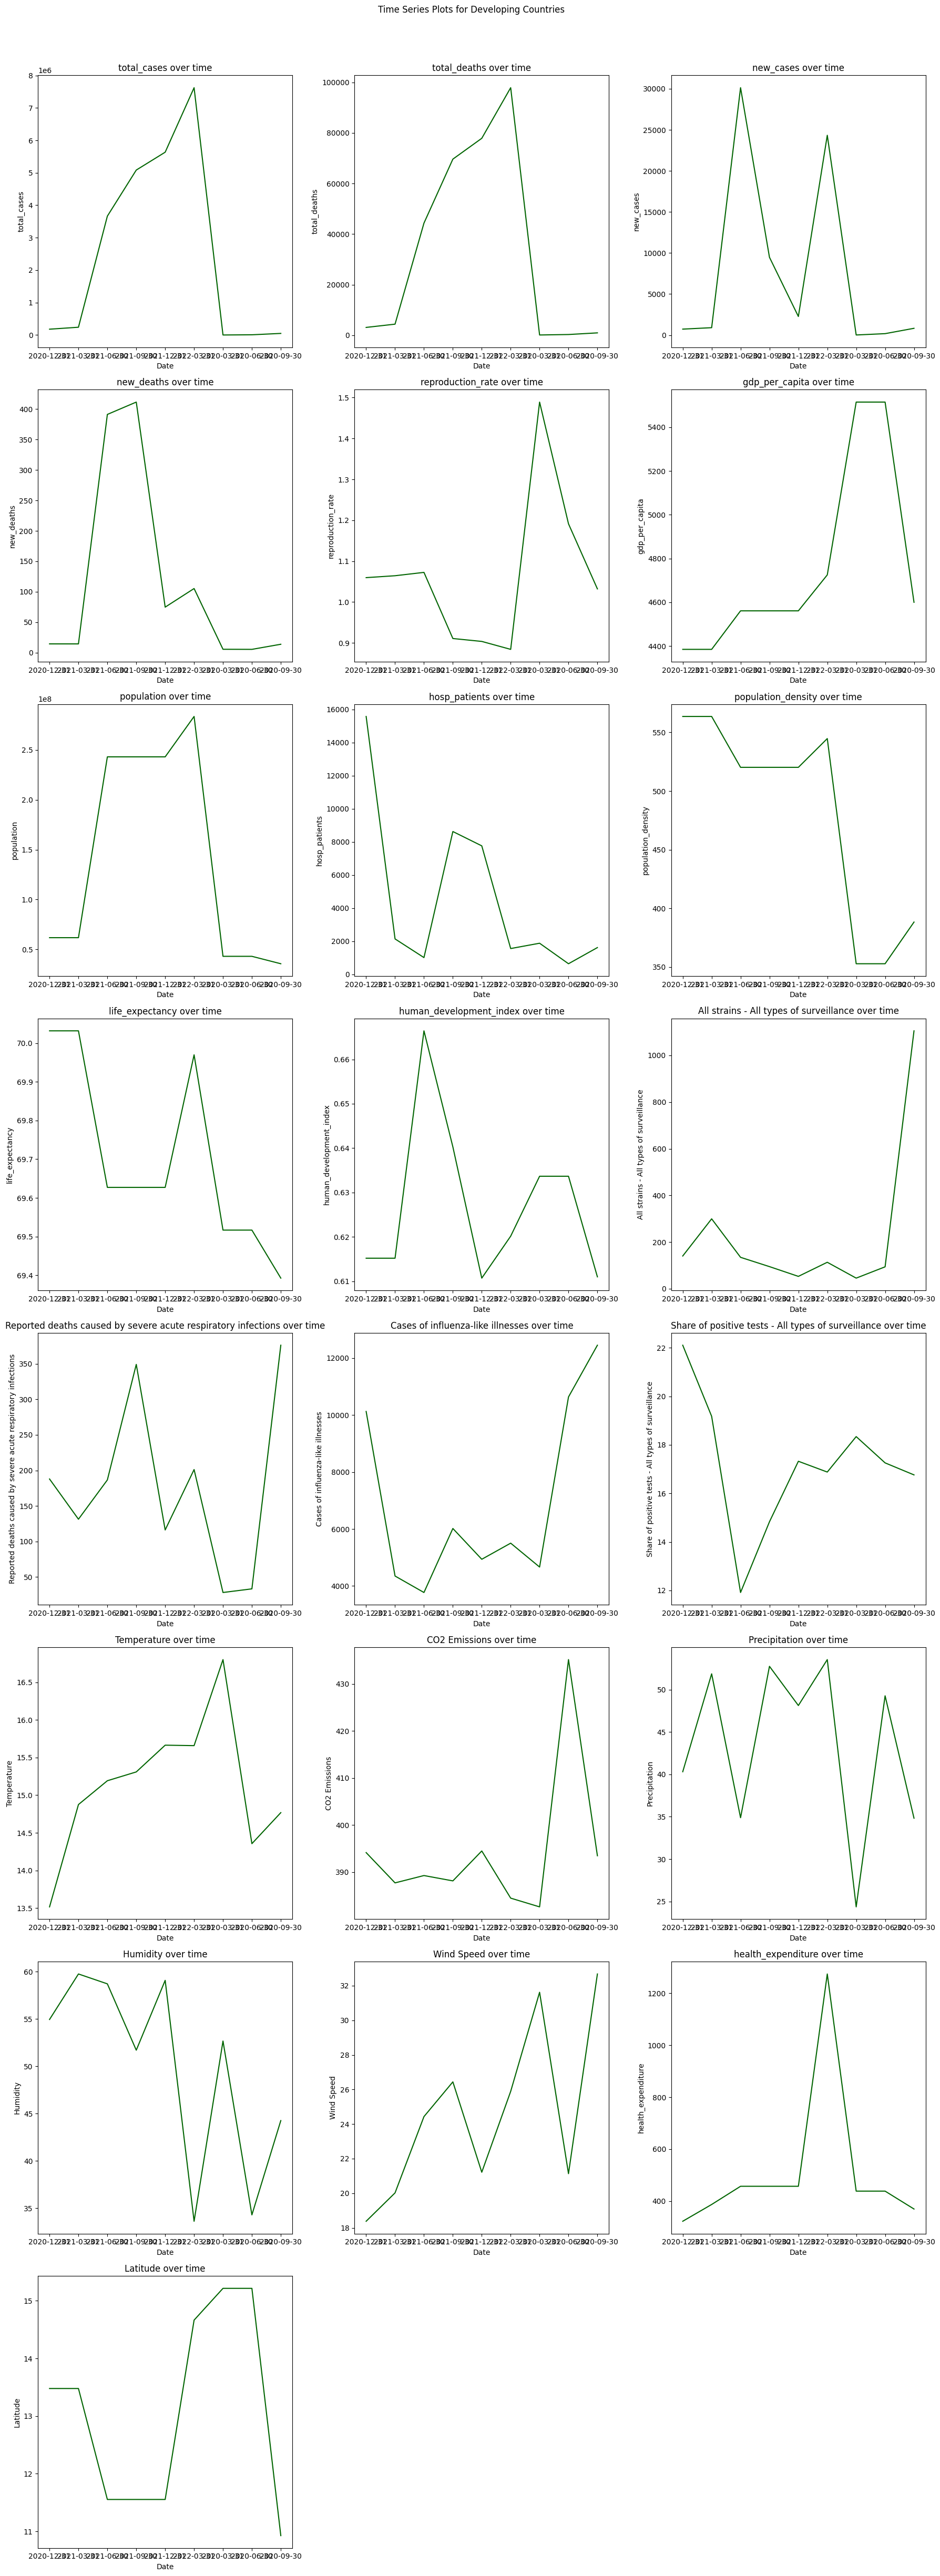

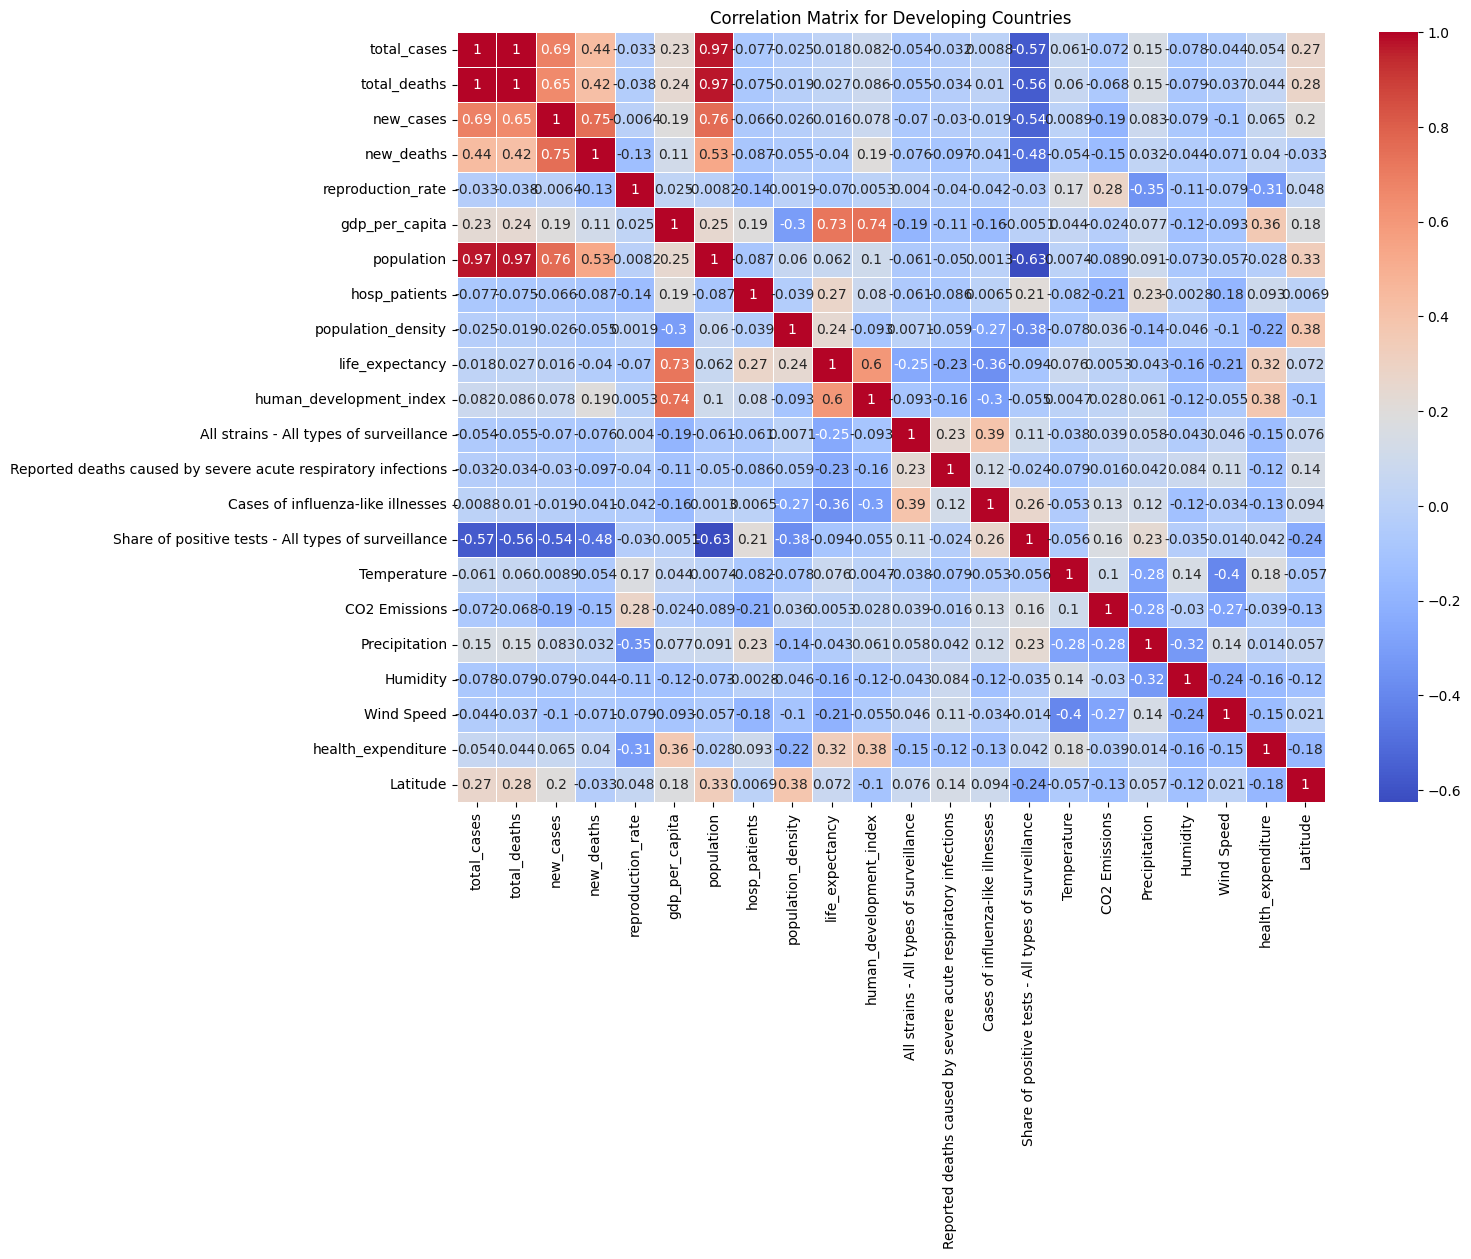


--- EDA for Underdeveloped Countries ---
Dimensions of the dataset: (72, 24)

First few rows of the dataset:
                     location        date  total_cases  total_deaths  \
884  Central African Republic  2020-03-31     2.411765     10.093750   
885  Central African Republic  2020-03-31     2.411765     10.093750   
886  Central African Republic  2020-03-31     2.411765     10.093750   
887  Central African Republic  2020-03-31     2.411765     10.093750   
888  Central African Republic  2020-06-30   907.120879     14.589744   

     new_cases  new_deaths  reproduction_rate  gdp_per_capita  population  \
884   0.176471    0.255556           0.573279          661.24   4919987.0   
885   0.176471    0.255556           0.573279          661.24   4919987.0   
886   0.176471    0.255556           0.573279          661.24   4919987.0   
887   0.176471    0.255556           0.573279          661.24   4919987.0   
888  41.120879    1.205128           1.045849          661.24   4919987.

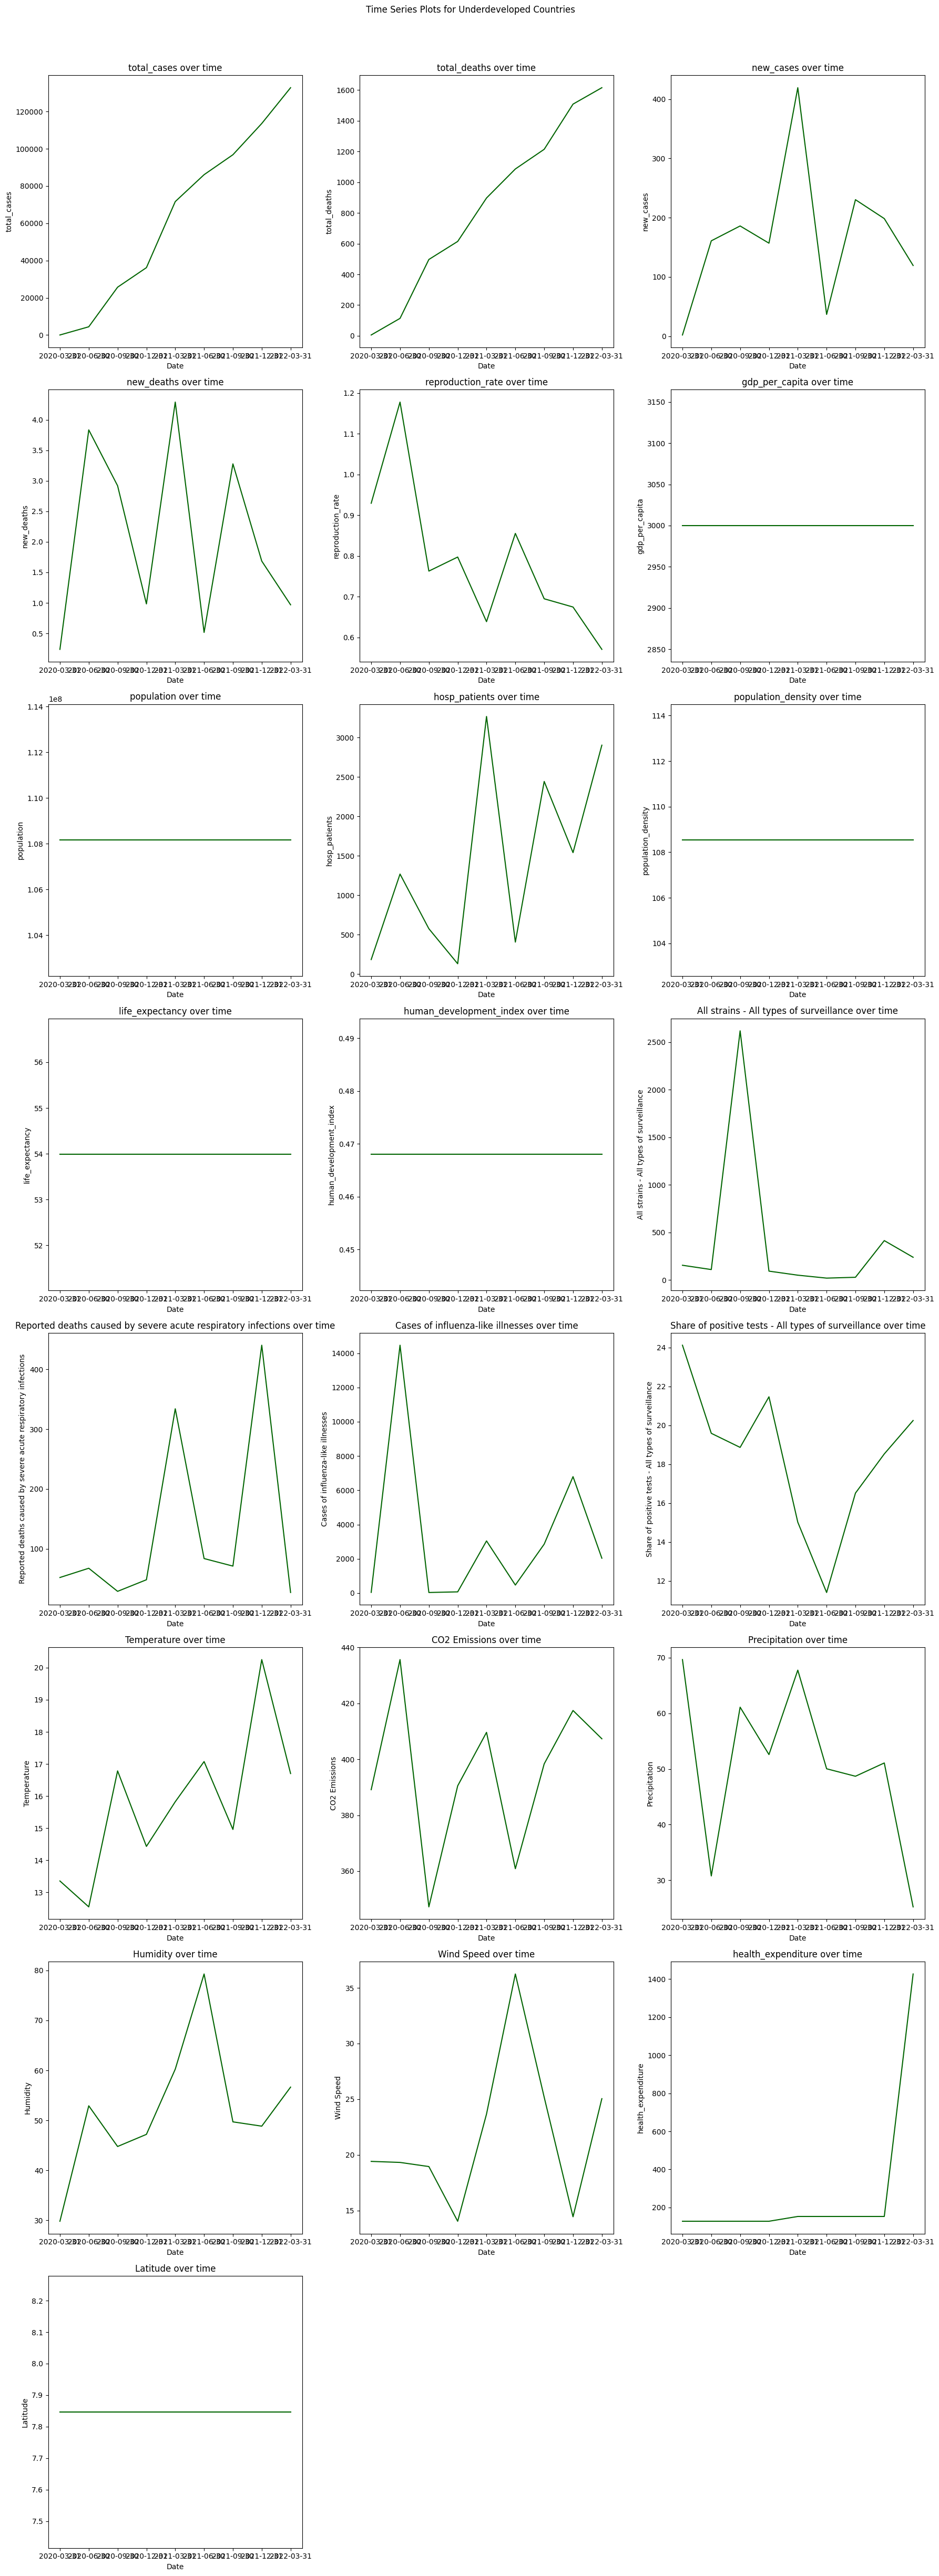

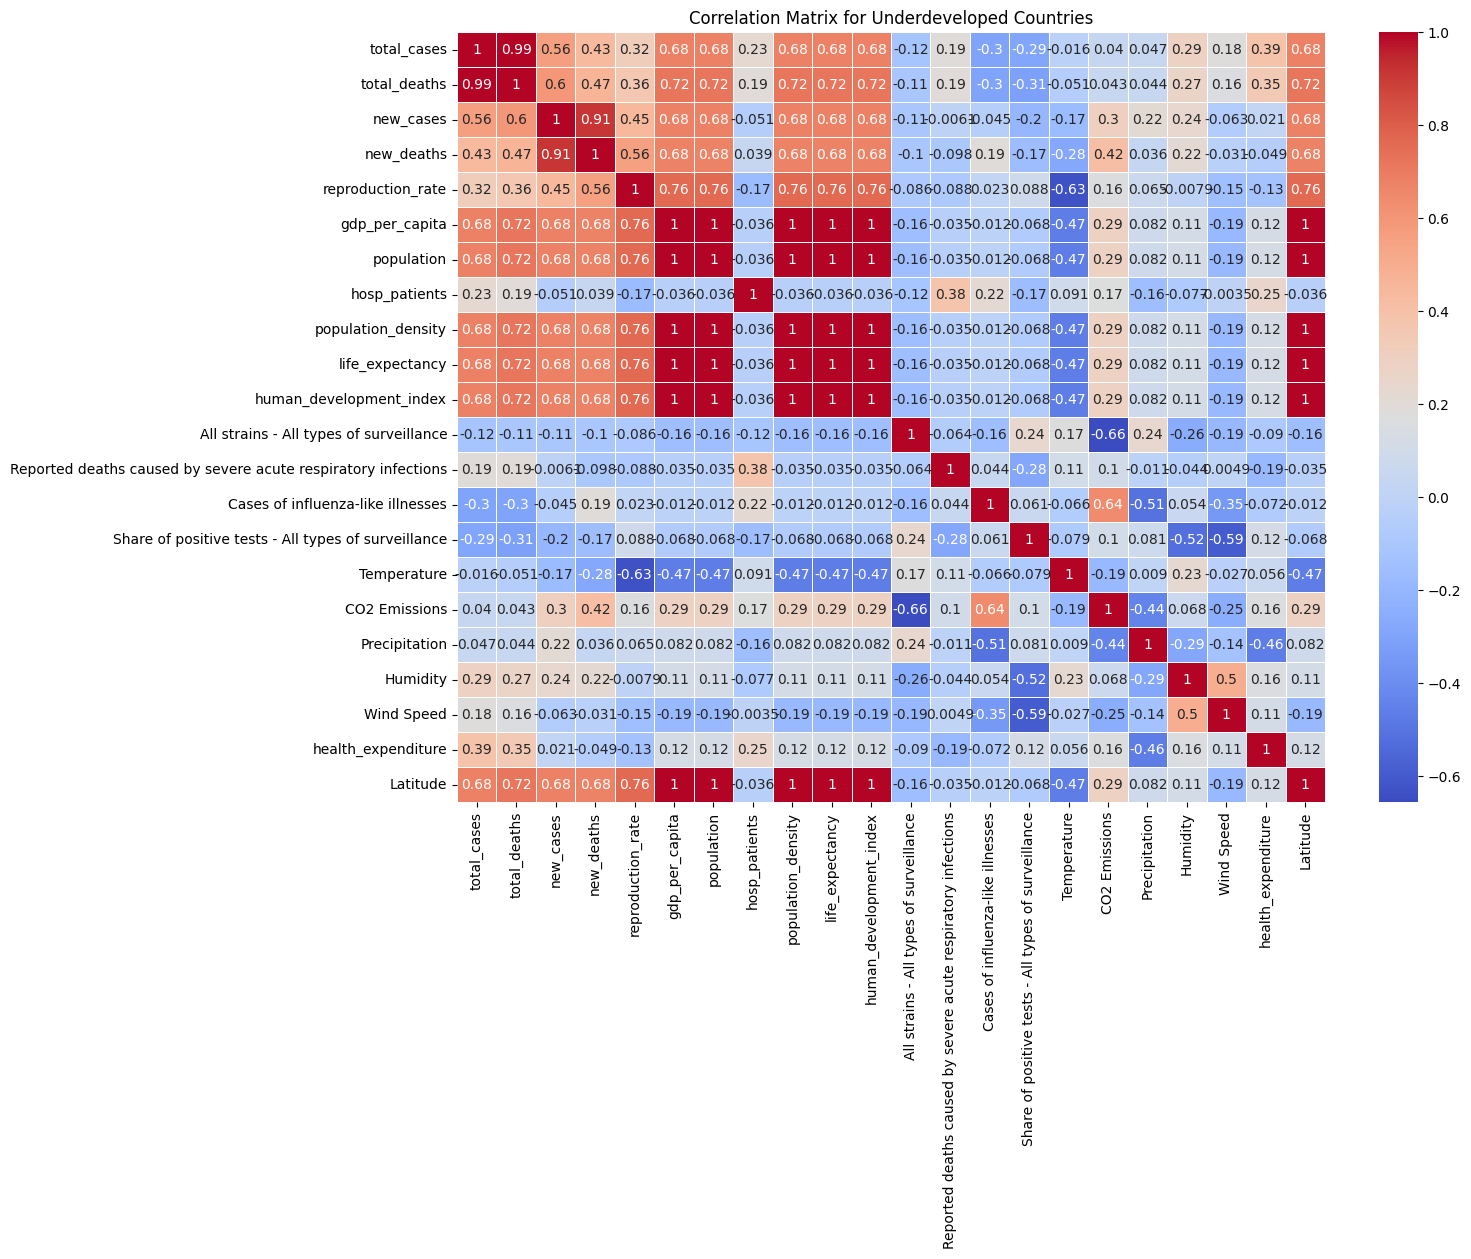


--- EDA for Island Countries ---
Dimensions of the dataset: (320, 24)

First few rows of the dataset:
      location        date  total_cases   total_deaths  new_cases  new_deaths  \
1176  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1177  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1178  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1179  Dominica  2020-03-31     7.900000  220484.956044   1.200000    0.428571   
1180  Dominica  2020-06-30    16.417582  105840.043478   0.065934    4.888889   

      reproduction_rate  gdp_per_capita  population  hosp_patients  ...  \
1176           1.032609        9673.367     72172.0      55.393939  ...   
1177           1.032609        9673.367     72172.0      55.393939  ...   
1178           1.032609        9673.367     72172.0      55.393939  ...   
1179           1.032609        9673.367     72172.0      55.393939  ...   
1180           1.072088        9673

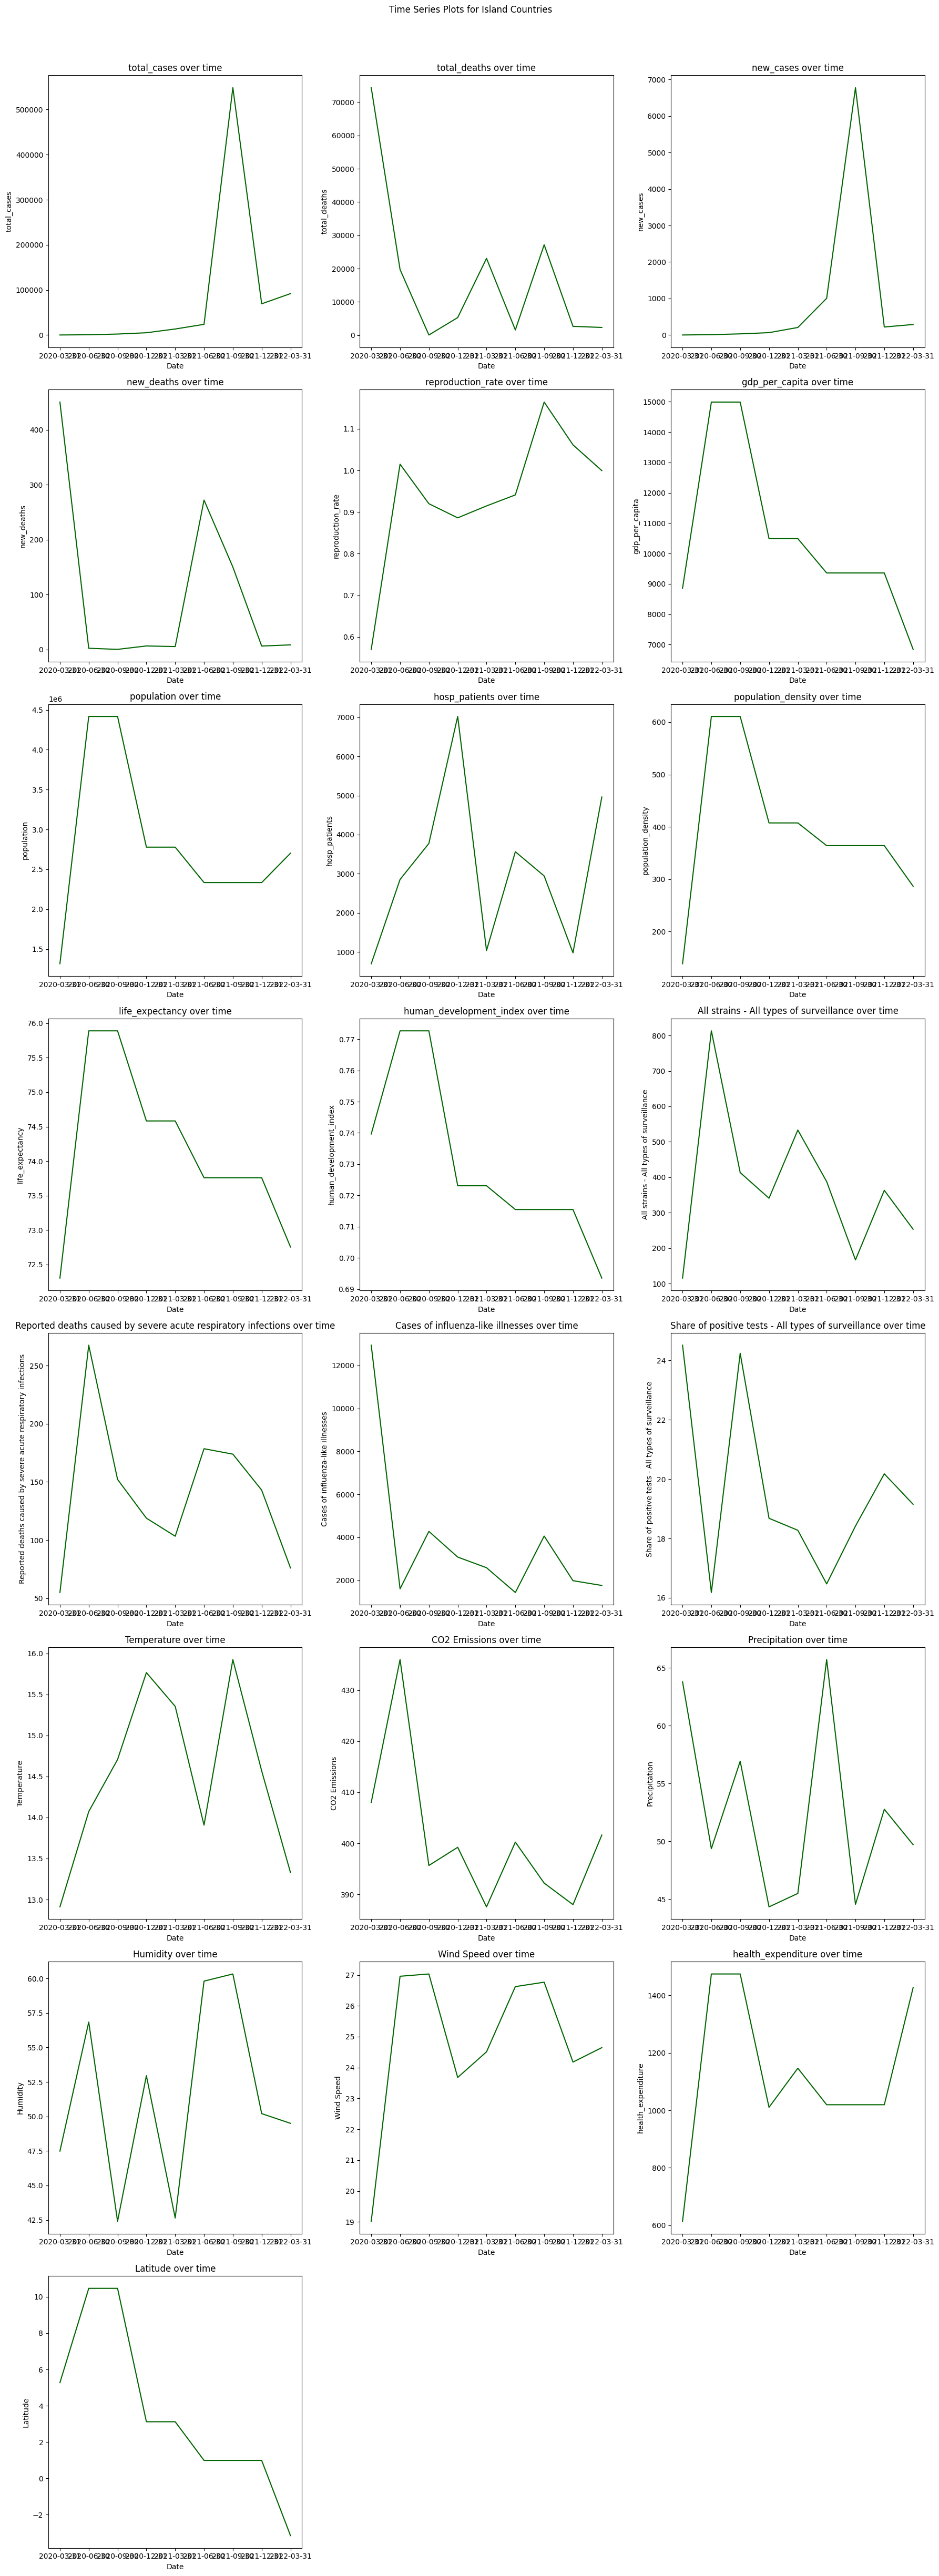

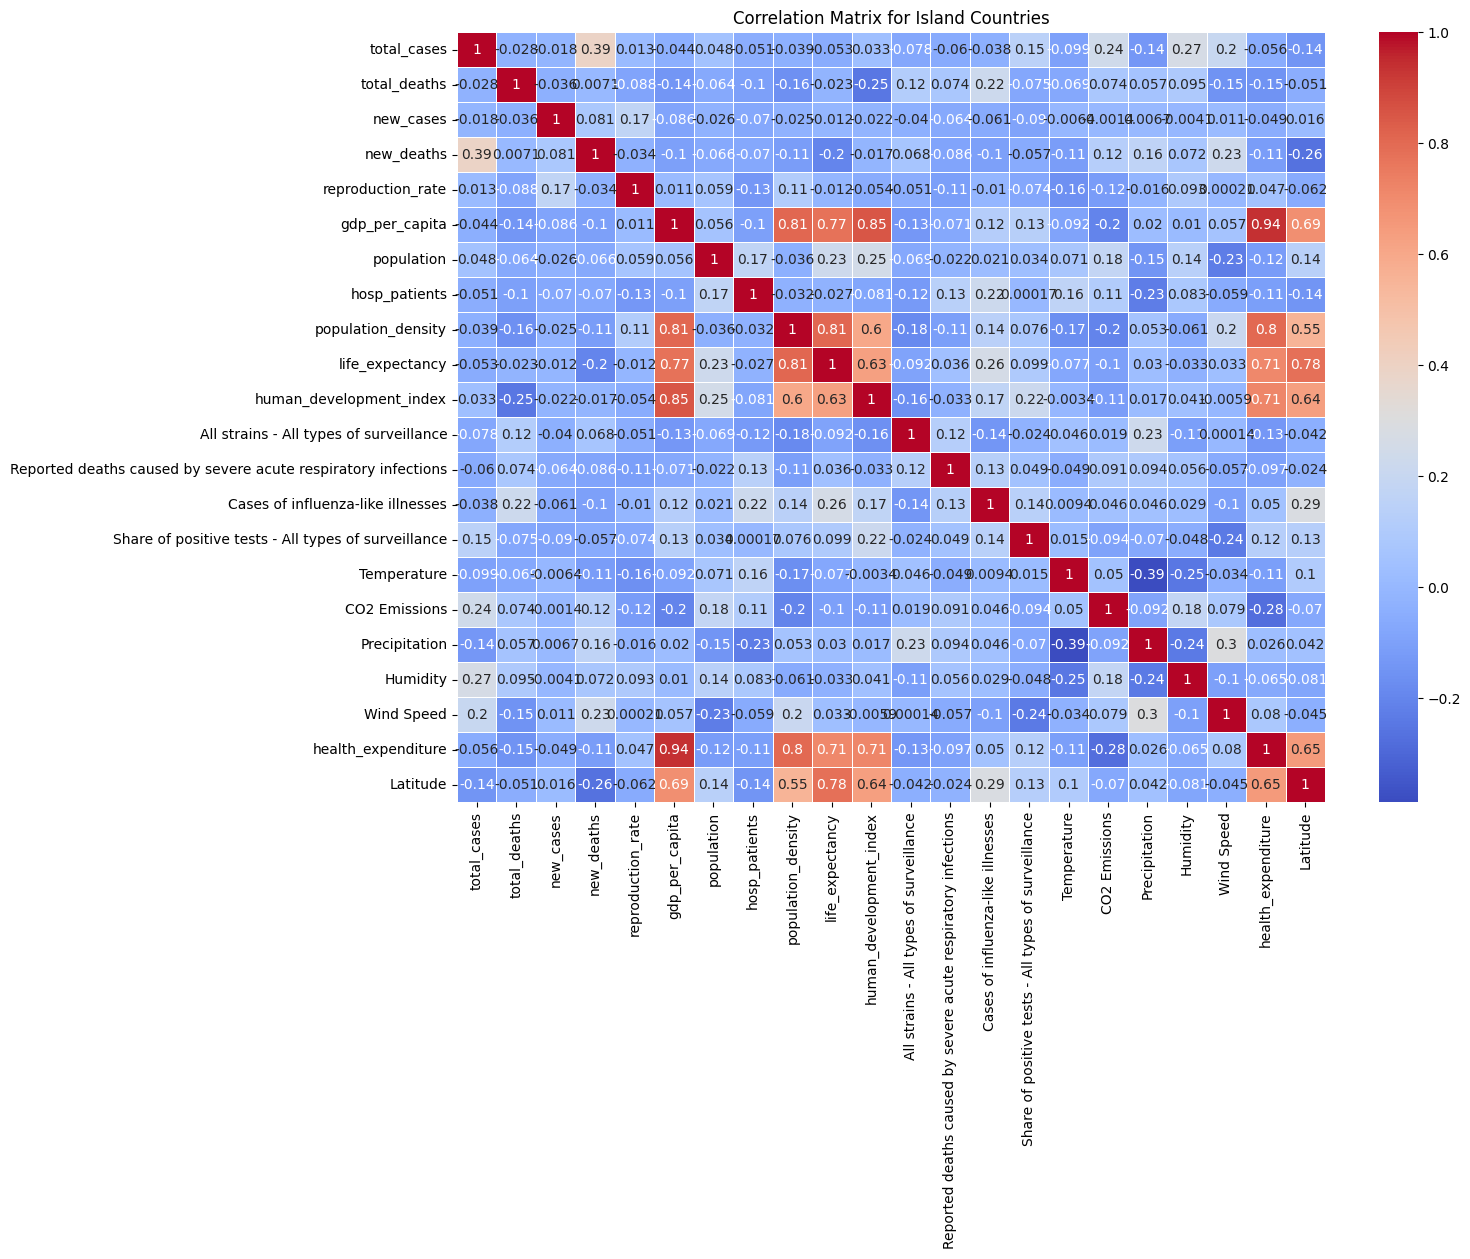

In [20]:
#EDA

# Define country lists for each category
developed_countries = ['Singapore', 'Bahrain', 'Barbados', 'Mauritius', 'Lebanon', 'South Korea', 'Syria', 'Israel', 'Belgium', 'Japan']
developing_countries = ['Bangladesh', 'Rwanda', 'South Sudan', 'India', 'Haiti', 'Tuvalu', 'Philippines', 'Vietnam', 'El Salvador']
underdeveloped_countries = ['Nigeria', 'Central African Republic']
island_countries = ['Marshall Islands', 'St. Vincent and the Grenadines', 'Jamaica', 'Tonga', 'Kiribati', 'Dominica', 'Samoa', 'Fiji', 'Vanuatu', 'Solomon Islands', 'Maldives', 'Malta', 'Saint Lucia', 'Sri Lanka']


# Check for missing values and handle them
project_merged_data = project_merged_data.dropna(subset=['date', 'total_cases', 'total_deaths'])

# Define a function for EDA
def perform_eda(data, category_name):
    print(f"\n--- EDA for {category_name} Countries ---")

    if data.empty:
        print(f"No data available for {category_name} countries.")
        return

    # Check the dimensions of the dataset
    print("Dimensions of the dataset:", data.shape)

    # Display the first few rows
    print("\nFirst few rows of the dataset:")
    print(data.head())

    # Check for missing values
    print("\nMissing values in each column:")
    print(data.isnull().sum())

    # Summary statistics
    print("\nSummary statistics for numerical variables:")
    print(data.describe())

# Univariate Analysis with line plots
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    num_plots = len(numeric_columns)
    num_cols = 3
    num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

    plt.figure(figsize=(18, num_rows * 6))
    for i, column in enumerate(numeric_columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.lineplot(x=data['date'], y=data[column], errorbar=None, color='darkgreen')
        plt.title(f'{column} over time')
        plt.xlabel('Date')
        plt.ylabel(column)

    plt.tight_layout()
    plt.suptitle(f'Time Series Plots for {category_name} Countries', y=1.02)
    plt.show()



    # Correlation matrix
    numeric_data = data.select_dtypes(include=[np.number])
    if not numeric_data.empty:
        plt.figure(figsize=(14, 10))
        correlation_matrix = numeric_data.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title(f'Correlation Matrix for {category_name} Countries')
        plt.show()
    else:
        print("No numeric data available for correlation matrix.")

# Filter data for each category
developed_data = project_merged_data[project_merged_data['location'].isin(developed_countries)]
developing_data = project_merged_data[project_merged_data['location'].isin(developing_countries)]
underdeveloped_data = project_merged_data[project_merged_data['location'].isin(underdeveloped_countries)]
island_data = project_merged_data[project_merged_data['location'].isin(island_countries)]

# Perform EDA for each category
perform_eda(developed_data, "Developed")
perform_eda(developing_data, "Developing")
perform_eda(underdeveloped_data, "Underdeveloped")
perform_eda(island_data, "Island")